# Аугментация

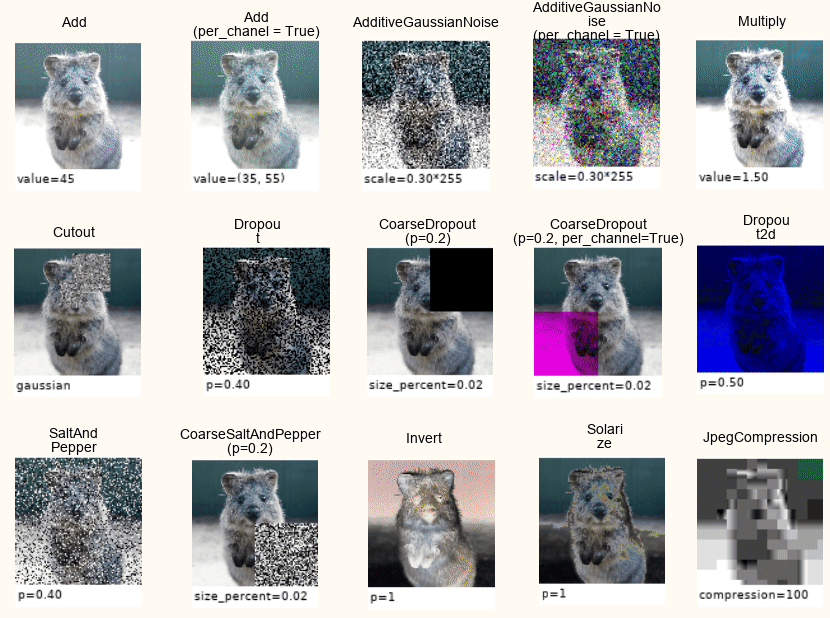

Рассказ про то, почему это нужно и что здесь хорошего

In [92]:
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

# custom
import imgaug as ia
from model import Net
from train import accuracy, train_model
from dataset import CatDogDataset, read_img_test, read_random_images
from helpers import display_images

from torchvision.models import resnet50
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

ia.seed(1)
plt.rcParams["figure.figsize"] = (15,6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ВАЖНО результат выполнения кода в этой ячейки должен быть cuda для правильного работы ноутбука
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

cuda


In [3]:
# Открываем изображение
img = cv2.imread(f'cat.jpg', cv2.IMREAD_COLOR) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)

In [7]:
def apply_augment(aug, img):
    aug_img = aug.augment(image=img)
    plt.imshow(aug_img)
    plt.axis('off')

### Оригинальное фото


(-0.5, 3023.5, 4031.5, -0.5)

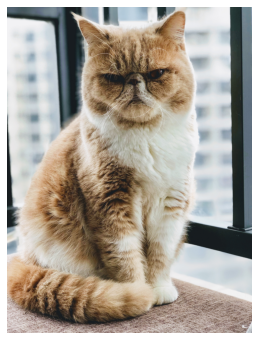

In [65]:
plt.imshow(img)
plt.axis('off')

#### Аугментированные фото

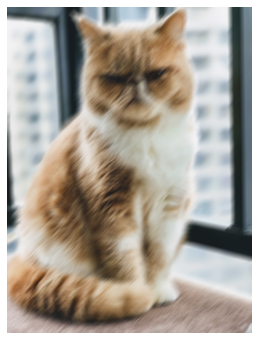

In [66]:
# canny
aug = iaa.MotionBlur(k=100)
apply_augment(aug, img)

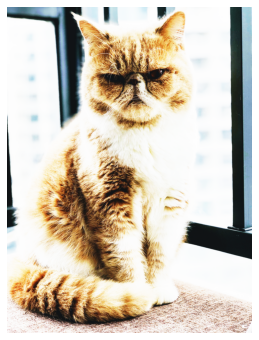

In [67]:
aug = iaa.SigmoidContrast(gain=(2, 11), cutoff=(0.1, 1))
apply_augment(aug, img)

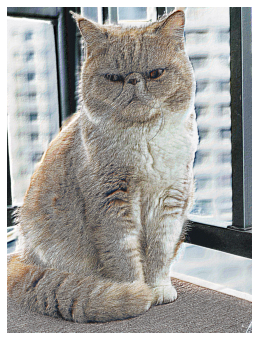

In [68]:
aug = iaa.Emboss(alpha=(0.0, 1.0), strength=(10, 100))
apply_augment(aug, img)

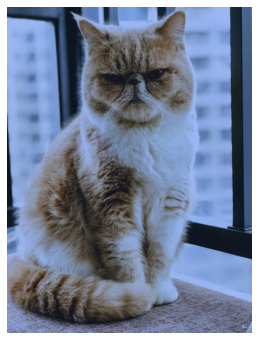

In [69]:
aug = iaa.ChangeColorTemperature((1100, 40000))
apply_augment(aug, img)

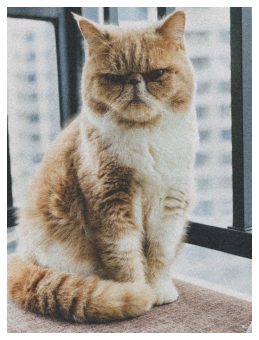

In [70]:
aug = iaa.AdditiveGaussianNoise(scale=(10, 500))
apply_augment(aug, img)

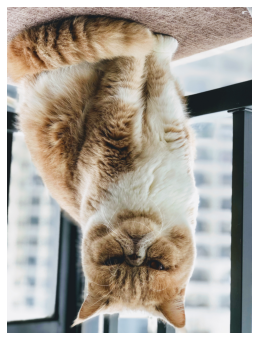

In [71]:
aug = iaa.flip.Flipud(p=1)
apply_augment(aug, img)

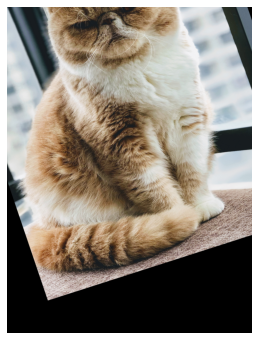

In [72]:
aug = iaa.Affine(
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    rotate=(-25, 25),
    shear=(-8, 8)
)
apply_augment(aug, img)

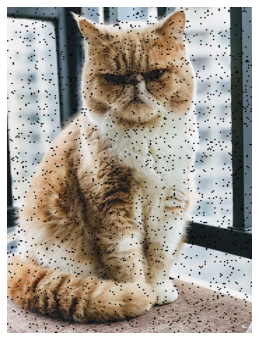

In [77]:
aug = iaa.CoarseDropout((0.0, 0.10), size_percent=(0.001, 0.1))
apply_augment(aug, img)

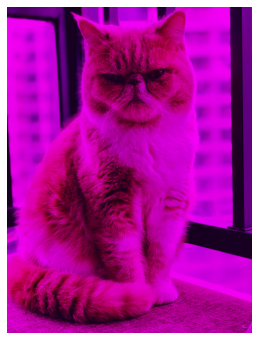

In [78]:
aug = iaa.Dropout2d(p=0.5)
apply_augment(aug, img)

Больше разных примеров по ссылке
https://github.com/aleju/imgaug

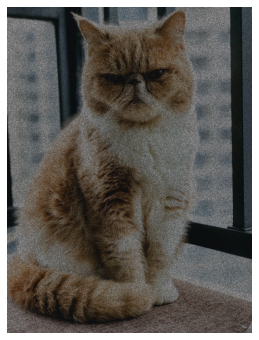

In [86]:
aug = iaa.CoarseDropout(0.5, size_percent=1)
apply_augment(aug, img)

In [16]:
# Рассказ про лямбда функцию
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

In [87]:
f = lambda x, y: x + y
f(2, 4)

6

In [90]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # Горизонтальный поворот
    iaa.Crop(percent=(0, 0.1)), # Случайные вырезы
    # добавить помутнение
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
    # Контраст изображения
    iaa.LinearContrast((0.75, 1.5)),
    # Добавить шум
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Scale/zoom, translate/move, поворачивать изорбражение.
    #Объяснить как работает sometimes на примере     
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], 
random_order=True) # Применить 

images = read_random_images(10, 'train')
images_aug = seq(images=images)

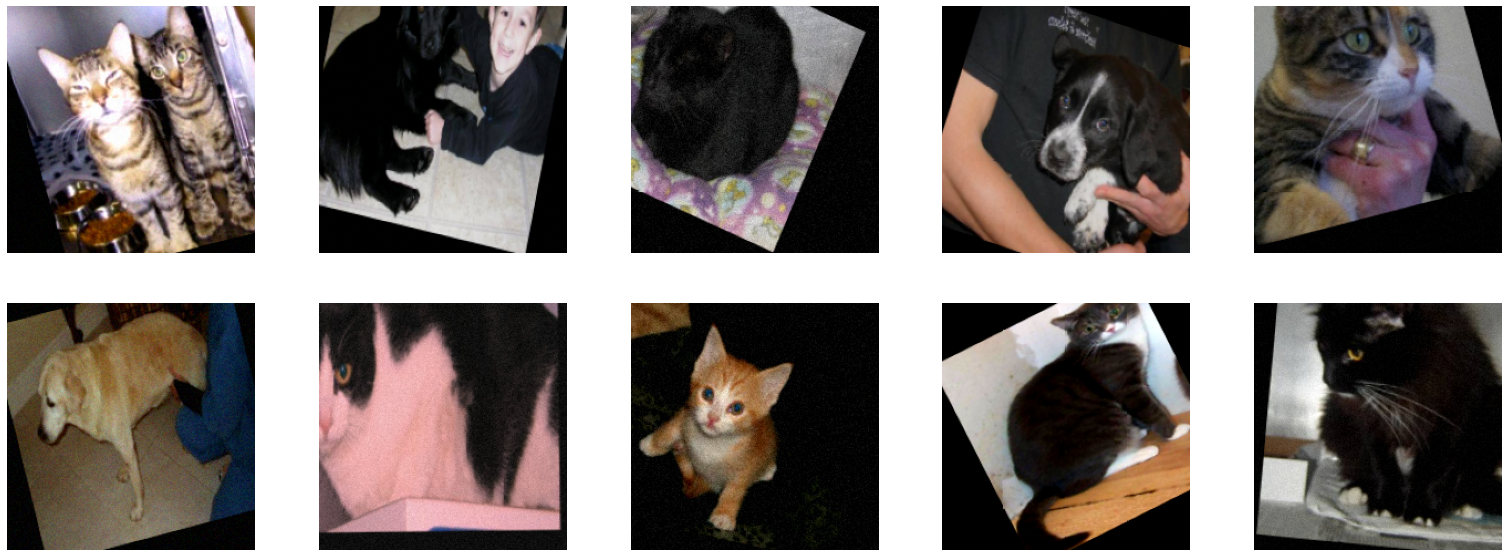

In [95]:
display_images(2, 5, images_aug)

# Создйте свой собственнный аугментатор

In [99]:
# Покажите как шаг за шагом собирался агментатор выше
# Создаем пустой список
augs = []

# Добавляем те аугментации, которые нам нравятся
augs.append(iaa.Multiply((0.8, 1.2), per_channel=0.2))
augs.append(iaa.Fliplr(0.5))

seq_ = iaa.Sequential(augs)
images = read_random_images(10, 'train')
images_aug = seq(images=images)

In [97]:
# Добавь сюда свою аугментацию из примера выше
augs = []

seq_student = iaa.Sequential(augs)
images = read_random_images(10, 'train')
images_aug = seq(images=images)

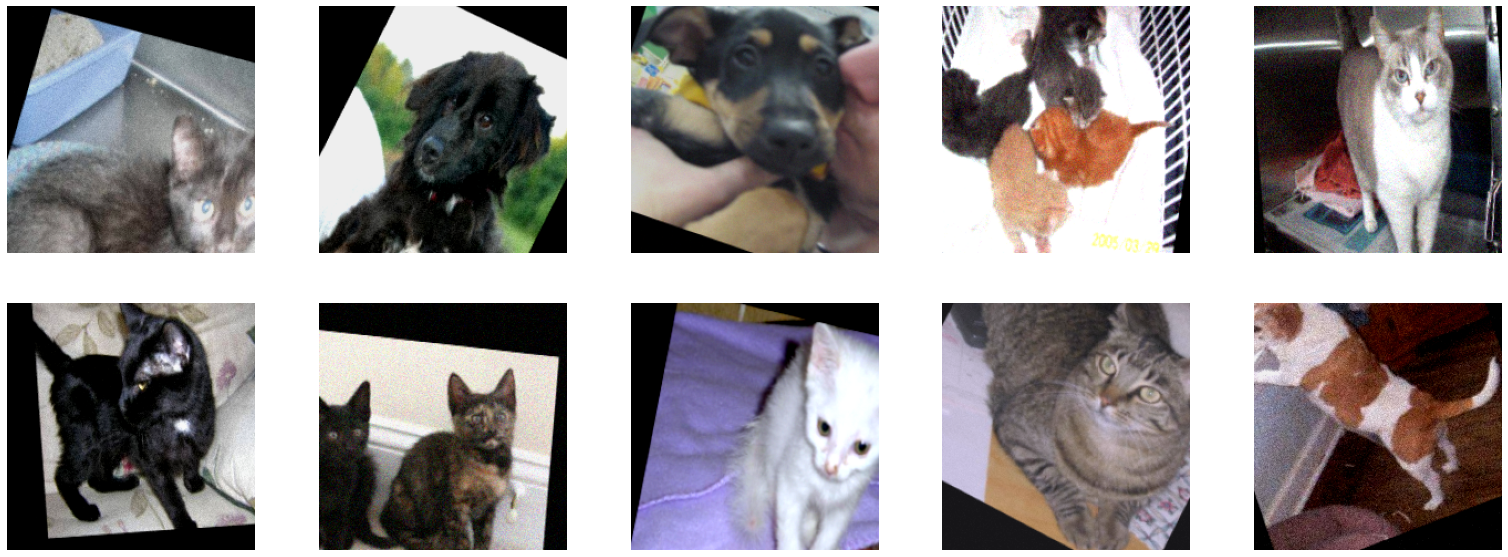

In [98]:
display_images(2, 5, images_aug)

# Добавляем свой аугментер в DataLoader

In [23]:
# Добавляем наш аугментатор
# Создаем переменную tf
tfs = transforms.Compose([
#     seq.augment_image,
    seq_student.augment_image, #Ваш аугментер
    transforms.ToTensor()
])
# Передаем переменную tfs на transforms
train_dataset = CatDogDataset(mode="train", transforms=tfs)
test_dataset = CatDogDataset(mode="val", transforms=tfs)

# Команда будет загружать каждый шаг 16 картинок и 16 ответов
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)
# Команда будет загружать каждый шаг только 16 картинок
test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

In [16]:
EPOCHS = 10

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
criterion = nn.BCELoss()

model.to(device)
# Запускаем процесс тренироки
logs = train_model(EPOCHS, 
                    model, 
                    train_data_loader, 
                    test_data_loader, 
                    optimizer, criterion)

  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 1 Точность: 60.26 Время : 48.7948


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 1 Точность: 58.766 Время : 5.9686


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 2 Точность: 65.315 Время : 48.8349


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 2 Точность: 64.8163 Время : 6.0901


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 3 Точность: 67.495 Время : 49.2911


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 3 Точность: 66.9728 Время : 5.998


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 4 Точность: 69.72 Время : 49.5954


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 4 Точность: 71.3059 Время : 5.8784


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 5 Точность: 71.11 Время : 48.9181


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 5 Точность: 72.0847 Время : 5.8666


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 6 Точность: 72.635 Время : 48.4673


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 6 Точность: 73.8818 Время : 6.2971


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 7 Точность: 73.52 Время : 49.4902


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 7 Точность: 71.7452 Время : 5.856


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 8 Точность: 74.38 Время : 49.1877


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 8 Точность: 74.4409 Время : 6.0699


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 9 Точность: 75.28 Время : 49.982


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 9 Точность: 73.143 Время : 6.4952


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 10 Точность: 75.96 Время : 50.4111


100%|██████████| 313/313 [00:06<00:00, 51.49it/s]


Проверка
Эпоха 10 Точность: 76.238 Время : 6.0811


Тренировка большего кол-ва эпох без падения точности

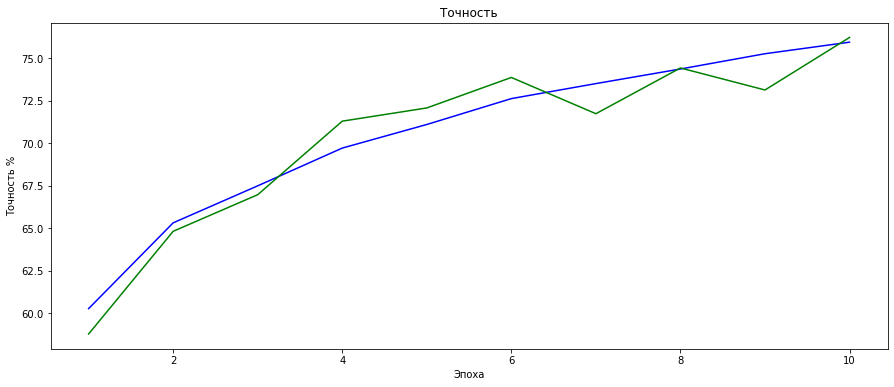

In [18]:
#Точность
plt.title("Точность")
plt.plot(np.arange(1, EPOCHS+1, 1), logs[0]["accuracy"], color = 'blue')
plt.plot(np.arange(1, EPOCHS+1, 1), logs[1]["accuracy"], color = 'green')
plt.xlabel("Эпоха")
plt.ylabel("Точность %")
plt.show()

# Трансфер обучение

Описание про трансфер обучение и как оно используется

In [24]:
from torchsummary import summary

model = resnet50(pretrained = True)
model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Аналогия между "свои знания в чужую голову не положишь".

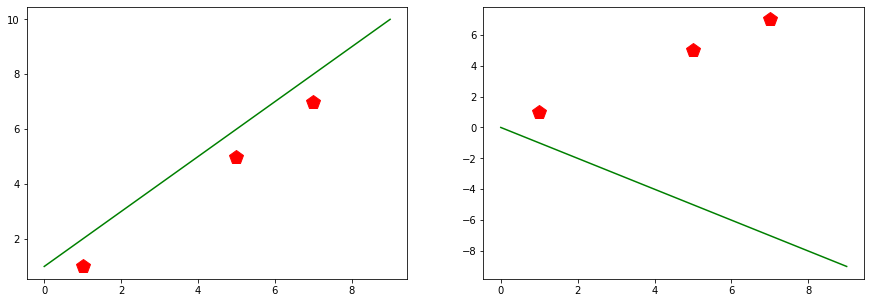

In [25]:
b, k = 1, 1
x = np.array(list(range(0, 10)))
y = x*b + k

_, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(1, 1, 'rp', markersize=14) 
ax[0].plot(5, 5, 'rp', markersize=14) 
ax[0].plot(7, 7, 'rp', markersize=14) 
ax[0].plot(x, y, '-g')  # solid green

b, k = -1, 0
x = np.array(list(range(0, 10)))
y = x*b + k

ax[1].plot(1, 1, 'rp', markersize=14) 
ax[1].plot(5, 5, 'rp', markersize=14) 
ax[1].plot(7, 7, 'rp', markersize=14) 
ax[1].plot(x, y, '-g')  # solid green

Задание на дом сохранить модель

In [27]:
EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
criterion = nn.BCELoss()
model.to(device)
logs = train_model(EPOCHS, 
                    model, 
                    train_data_loader, 
                    test_data_loader, 
                    optimizer, criterion)

  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 1 Точность: 94.91 Время : 144.0557


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 1 Точность: 96.4457 Время : 12.4693


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 2 Точность: 96.445 Время : 144.0209


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 2 Точность: 97.3043 Время : 12.4216


  0%|          | 0/313 [00:00<?, ?it/s]


Тренировка
Эпоха 3 Точность: 96.86 Время : 146.3548


  0%|          | 0/1250 [00:00<?, ?it/s]


Проверка
Эпоха 3 Точность: 96.7652 Время : 12.444


  2%|▏         | 20/1250 [00:02<02:39,  7.71it/s]


KeyboardInterrupt: 